In [19]:
%config InlineBackend.figure_format = 'retina' # For high-resolution.
import pandas as pd
import numpy as np
import pydicom as dicom
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import os

import torch 
from torch import Tensor
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torch.optim import Adam


import cv2
from tqdm.notebook import tqdm


import warnings
warnings.filterwarnings('ignore')

import segmentation_models_pytorch as smp
# from torchsampler import ImbalancedDatasetSampler


from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from scipy.stats import pearsonr
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import gc

In [2]:
## Hyperparameters
USERNAME = os.getcwd().split('/')[2]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
print(torch.cuda.device_count())

RESOLUTION = 512
BATCH_SIZE = 4
NUM_WORKERS = 4
PIN_MEMORY = True
DROP_LAST = True

LEARNING_RATE = 1e-4
NUM_EPOCHS = 10

THRESHOLD = 0.3
# MIN_ACTIVATION_SIZE = 


cuda
1


In [3]:
def read_df(df_type):
    #username = os.getcwd().split('/')[2]
    df_path = '/home/{}/teams/dsc-180a---a14-[88137]/CANDID_PTX_csv/{}.csv'.format(USERNAME, df_type)
    df = pd.read_csv(df_path)[['Mask_Path', 'XRay_Path', 'Intermediate_Predicted_Path']]
#     df = pd.read_csv(df_path)[['Mask_Path', 'XRay_Path']]
    df['Mask_Path'] = df['Mask_Path'].str.replace('anw008', USERNAME)
    df['XRay_Path'] = df['XRay_Path'].str.replace('anw008', USERNAME)
    df['Intermediate_Predicted_Path'] = df['Intermediate_Predicted_Path'].str.replace('anw008', USERNAME)
    df['SOP'] = df['XRay_Path'].apply(lambda x: x.split('/')[-1])
    
    df['No_Pneumothorax'] = df['Mask_Path'].str.contains('negative_mask').astype(int)
    df['Yes_Pneumothorax'] = 1 - df['No_Pneumothorax']
    
    
    return df

In [4]:
train_df = read_df('train')
val_df = read_df('validation')
test_df = read_df('test')
# left_df = read_df('unused_negative')
pos_df = read_df('train_pos')
neg_df = read_df('train_neg')

In [26]:
train_df.head()

,Mask_Path,XRay_Path,Intermediate_Predicted_Path,SOP,No_Pneumothorax,Yes_Pneumothorax
0,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,0.0.00.400800.30.9.2.0.97200258210.26537585746...,0,1
1,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,0.0.07.109556.72.6.9.7.18989625890.56335195975...,0,1
2,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,0.0.08.203506.65.2.5.0.32924650882.36087017673...,0,1
3,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,0.0.15.275672.29.0.5.8.45791925255.74232884473...,0,1
4,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,0.0.155.605300.6.541.1.9531666121.6286372288.6...,0,1


In [18]:
combine = pd.concat([train_df, left_df])
combine.head()

,Mask_Path,XRay_Path,SOP,No_Pneumothorax,Yes_Pneumothorax
0,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,0.0.00.400800.30.9.2.0.97200258210.26537585746...,0,1
1,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,0.0.07.109556.72.6.9.7.18989625890.56335195975...,0,1
2,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,0.0.08.203506.65.2.5.0.32924650882.36087017673...,0,1
3,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,0.0.15.275672.29.0.5.8.45791925255.74232884473...,0,1
4,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,0.0.155.605300.6.541.1.9531666121.6286372288.6...,0,1


In [33]:
combine['Intermediate_Predicted_Path'] = combine['XRay_Path'].str.replace('CANDID_PTX', 'CANDID_PTX_PREDS').apply(lambda x: x + '_predicted.png')


In [39]:
pos_df = combine[combine['Yes_Pneumothorax'] == 1][['Mask_Path', 'XRay_Path', 'Intermediate_Predicted_Path']]
neg_df = combine[combine['Yes_Pneumothorax'] == 0][['Mask_Path', 'XRay_Path', 'Intermediate_Predicted_Path']]

In [40]:
pos_df.head()

,Mask_Path,XRay_Path,Intermediate_Predicted_Path
0,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...
1,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...
2,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...
3,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...
4,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...


In [46]:
# pos_df.to_csv('/home/{}/teams/dsc-180a---a14-[88137]/CANDID_PTX_csv/{}.csv'.format('mel011', 'train_pos'))
# neg_df.to_csv('/home/{}/teams/dsc-180a---a14-[88137]/CANDID_PTX_csv/{}.csv'.format('mel011', 'train_neg'))


Finish creating new csv for imbalanced data.

<hr>

In [5]:
class CANDID_PTX(Dataset):
    def __init__(self, df, resolution, model_type):
        self.img_paths = df['XRay_Path'].values
        self.intermediate_paths = df['Intermediate_Predicted_Path'].values
        self.mask_paths = df['Mask_Path'].values
        self.labels = torch.tensor(df[['Yes_Pneumothorax', 'No_Pneumothorax']].values, dtype=torch.float32)
        # Just changed by Angela
        self.sop = df['SOP'].values
        self.resolution = resolution
        
        # model_type: 'C' for Classification, 'S' for Segmentation, 'E' for Ensemble
        self.model_type = model_type
              
        return
            
    
    def __len__(self):
        
        return self.img_paths.shape[0]
    
    
    def __getitem__(self, idx):
        if self.model_type == 'E':
            # Designed for ensemble model's classification part
            label = self.labels[idx]
            
            new_img_path = self.intermediate_paths[idx]
            new_img = plt.imread(new_img_path)[:, :, :3]
            to_tensor = transforms.ToTensor()
            new_img = to_tensor(new_img)
            
            return new_img, label
        
        else:
            img_path = self.img_paths[idx]
            img = dicom.dcmread(img_path).pixel_array
            img_min = np.min(img)
            img_max = np.max(img)
            img_norm = (img - img_min) / (img_max - img_min)
            img_norm = cv2.resize(img_norm, (self.resolution, self.resolution))
            img_norm = torch.tensor(img_norm).expand(3, self.resolution, self.resolution)

            if self.model_type == 'C':
                # Designed for classification model
                label = self.labels[idx]

                return img_norm, label

            elif self.model_type == 'S':
                # Designed for segmentaion models (might change later)
                mask_path = self.mask_paths[idx]
                mask = plt.imread(mask_path)[:, :, 0]
                mask = cv2.resize(mask, (self.resolution, self.resolution))
    #             mask = np.where(mask < 0.5, 0, 1)
                mask = torch.tensor(mask).expand(1, self.resolution, self.resolution) 
        
                sop = self.sop[idx]

                return img_norm, mask, sop

In [6]:
def create_loaders(model_type):
    train_ds = CANDID_PTX(train_df, RESOLUTION, model_type)
    val_ds = CANDID_PTX(val_df, RESOLUTION, model_type)
    test_ds = CANDID_PTX(test_df, RESOLUTION, model_type)
    
    train_loader = DataLoader(train_ds, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, 
                          pin_memory = PIN_MEMORY, drop_last = DROP_LAST, shuffle = True)

    val_loader = DataLoader(val_ds, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, 
                              pin_memory = PIN_MEMORY, drop_last = DROP_LAST, shuffle = False)

    test_loader = DataLoader(test_ds, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, 
                              pin_memory = PIN_MEMORY, drop_last = DROP_LAST, shuffle = False)
    
    
    return train_loader, val_loader, test_loader

In [7]:
def create_train_loaders(num_neg, model_type):
    cur_df = pd.concat([pos_df, neg_df.sample(n=num_neg, replace=False)]).sample(frac=1, ignore_index=True)
    train_ds = CANDID_PTX(cur_df, RESOLUTION, model_type)

    train_loader = DataLoader(train_ds, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, 
                          pin_memory = PIN_MEMORY, drop_last = DROP_LAST, shuffle = True)

    return train_loader, cur_df.shape[0]

In [8]:
loaders_class = create_loaders('C')

# train_loaders_v1 = create_train_loaders(cur_df, 'C')

In [9]:
# ### Test dataloader
# sample_iter = iter(train_loaders_v1)
# sample = next(sample_iter)
# sample_2 = next(sample_iter)
# print("--Check length of first batch, should be 3")
# print(len(sample))
# print("--Check size of input images of first batch, should be ([{}, {}, {}, {}])".format(BATCH_SIZE, 3, RESOLUTION, RESOLUTION))
# print(sample[0].size())
# print(sample[0][0])
# print("--Check size of labels/masks of first batch")
# print(sample[1].size())
# print(sample[1][0])

In [10]:
### Modifying model
class resnet34(nn.Module):

    """

    Best to use pre-trained

    """

    def __init__(self):

        super().__init__()

        self.model = models.resnet34(pretrained=True)

        layers = np.array([layer for layer in self.model.children()])
        
        for layer in layers[:-2]:

            for param in layer.parameters():
                
                # Change parameters for all layers
                param.requires_grad = False
                
        self.model.fc = nn.Linear(512, 2)

    def forward(self, x):

        x = self.model(x)

        return x

In [11]:
def training_class(model, num_epochs, batch_size, learning_rate, 
                    train_loader, val_loader):
    
    model.to(DEVICE)
    
    all_train_loss = []
    all_val_loss = []
#     all_preds = []
#     all_masks = []
#     all_xray = []
    
    optimizer = Adam(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    scaler = torch.cuda.amp.GradScaler()
    
    pos_num = pos_df.shape[0]
    
    for epoch in tqdm(range(num_epochs)):
        total_train_loss = 0
        batch_num = 0
        model.train()
        
        if epoch == 3:
            train_loader, cur_num = create_train_loaders(pos_num, 'C')
            print('current number of training set is: {}'.format(cur_num))

        
        if epoch == 6:
            train_loader, cur_num = create_train_loaders(pos_num*2, 'C')
            print('current number of training set is: {}'.format(cur_num))
        
        if epoch == 9:
            train_loader, cur_num = create_train_loaders(pos_num*4, 'C')
            print('current number of training set is: {}'.format(cur_num))
        
        if epoch == 12:
            train_loader, cur_num = create_train_loaders(neg_df.shape[0], 'C')
            print('current number of training set is: {}'.format(cur_num))
        
        for i, (imgs, labels) in enumerate(train_loader):
            batch_num += 1
            
            imgs, labels = imgs.to(DEVICE, dtype=torch.float), labels.to(DEVICE, dtype=torch.float)
            
            optimizer.zero_grad()
            preds = model(imgs)
            
            
            if (i == 0) & (epoch == 0):
                print(preds)
                print(labels)

            
            loss = loss_fn(preds, labels)
    
            loss.backward()
            optimizer.step()
            
            total_train_loss += float(loss)
            
            
        if epoch % 3 == 0:
            print("Total # of training batch: ", i + 1)

        all_train_loss.append(total_train_loss / batch_num)
            
            
    ## validation set
        batch_num = 0
        total_val_loss = 0
        model.eval()
#         print("LET'S START VALIDATION!!!")
        for i, (imgs, labels) in enumerate(val_loader):
            batch_num += 1
            
            imgs, labels = imgs.to(DEVICE, dtype=torch.float), labels.to(DEVICE, dtype=torch.float)
            
            preds = model(imgs)
            
            loss = loss_fn(preds, labels) # is this mean or sum?

            total_val_loss += float(loss) # accumulate the total loss for this epoch.
            
#             if i == 1:
#                 all_preds.append(preds.detach().cpu())
#                 all_masks.append(masks.detach().cpu())
#                 all_xray.append(imgs.detach().cpu())
            
        if epoch == 0:
            print("Total # of validation batch: ", i + 1)

        all_val_loss.append(total_val_loss / batch_num)
        
    
    #plot_both_loss(all_train_loss, all_val_loss)
        
    return model, all_train_loss, all_val_loss#, all_preds, all_masks, all_xray

In [12]:
model_class = resnet34()

In [13]:
resnet_model, train_loss, val_loss = training_class(model = model_class,
                                            num_epochs = 15, batch_size = BATCH_SIZE,
                                            learning_rate = LEARNING_RATE,
                                            train_loader = loaders_class[0], val_loader = loaders_class[1])

  0%|          | 0/15 [00:00<?, ?it/s]

tensor([[ 0.6522, -0.0380],
        [ 0.8834,  0.2623],
        [ 0.4377,  0.1288],
        [ 0.4608, -0.0599]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.]], device='cuda:0')
Total # of training batch:  1278


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Total # of validation batch:  480


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

current number of training set is: 5112


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Total # of training batch:  1278


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

current number of training set is: 7668


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Total # of training batch:  1917


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

current number of training set is: 12780


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Total # of training batch:  3195


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

current number of training set is: 15397


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Total # of training batch:  3849


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

In [14]:
def plot_both_loss(all_train_loss, all_val_loss, model_name, resolution):
    plt.figure(figsize=(20, 10))
    sns.set(style="whitegrid")
    epoch_num = len(all_train_loss)
    df = pd.DataFrame({'x':range(epoch_num),
                    'train_loss':all_train_loss,
                      'val_loss':all_val_loss})
    df = df.set_index('x')
    
    train_val_loss = sns.lineplot(data=df, linewidth=2.5)

    ## now label the y- and x-axes.
    plt.ylabel('BCE Loss')
    plt.xlabel('Epoch Number')
    plt.title('BCE Loss of {} with resolution {}'.format(model_name, resolution))
    plt.show()
    
    fig = train_val_loss.get_figure()
    #fig.save('train_val_loss.png')

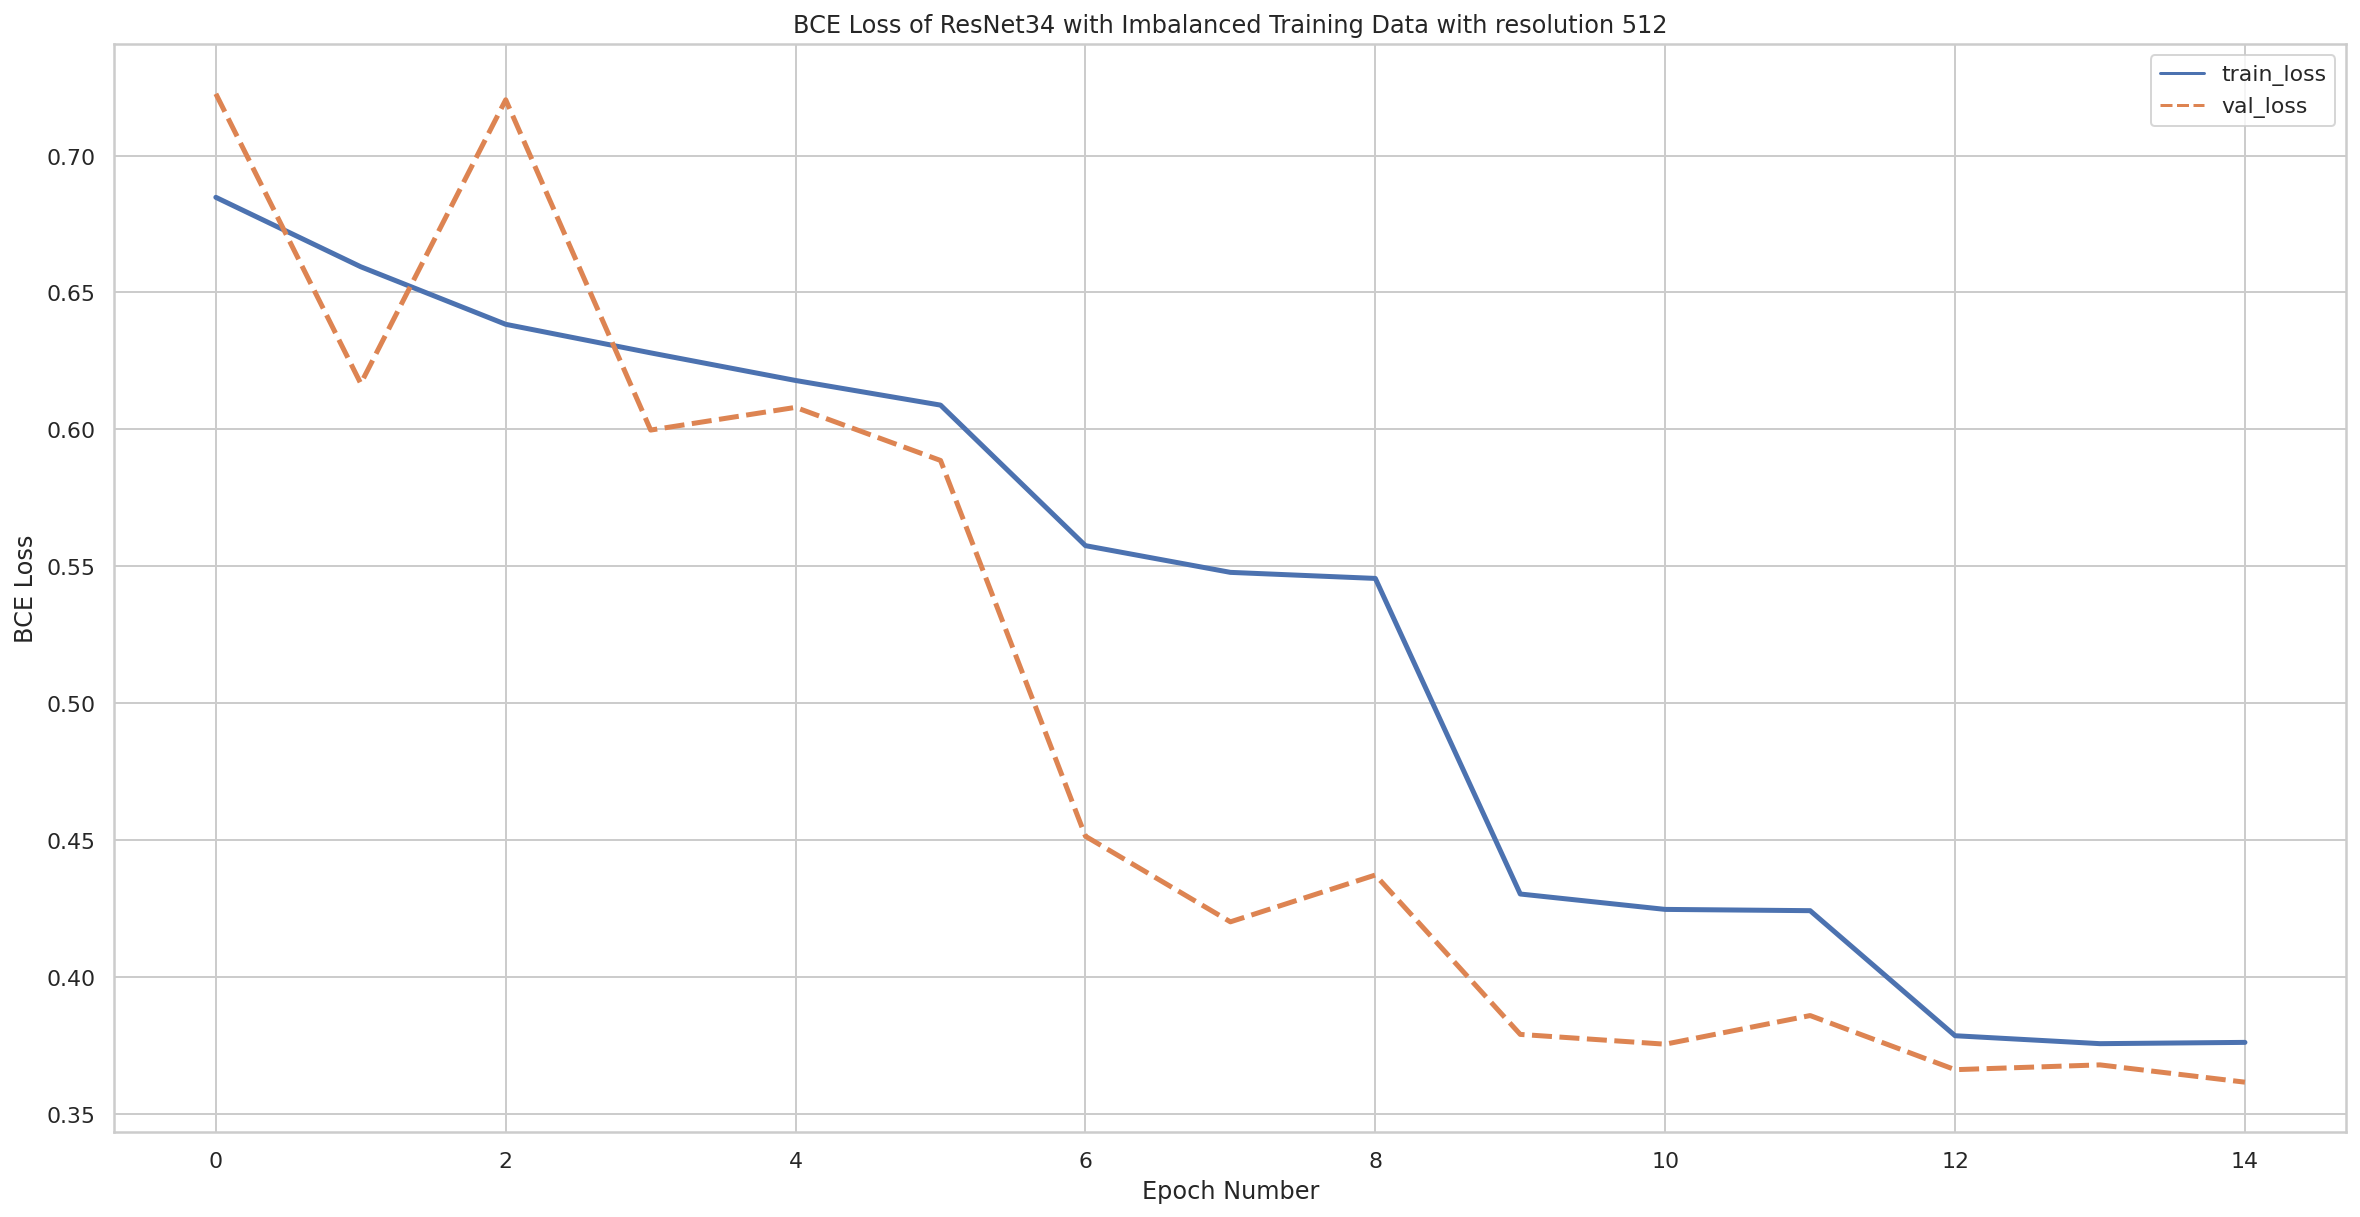

In [15]:
plot_both_loss(train_loss, val_loss, "ResNet34 with Imbalanced Training Data", str(RESOLUTION))

In [16]:
def plot_confusion_matrix(y_test, y_true, model_name, resolution):
    
    cm = confusion_matrix(y_true, y_test)

    sns.heatmap(cm, annot=True, cmap = 'Blues', fmt="d")
    plt.title('Confusion matrix of model {} with resolution {}'.format(model_name, resolution))
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.show()

In [17]:
def plot_roc_curve(y_test, y_true, model_name, resolution):
    fpr, tpr, threshold = roc_curve(y_true, y_test, drop_intermediate = False)
    roc_auc = roc_auc_score(y_true, y_test)

    plt.figure(1)
    plt.plot([0, 1], [0, 1])
    plt.plot(fpr, tpr, label='{}(area = {:.3f})'.format(model_name, roc_auc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve of model {} with resolution {}'.format(model_name, resolution))
    plt.legend(loc='best')
    plt.show()

In [18]:
def test_metrics(test_loader, model, model_name, resolution):
    """
    Calculate confusion matrix & auc-roc
    Return a list 
    """
    y_test = np.array([])
    y_true = np.array([])
    total_num_batch = 0
    for i, (imgs, labels) in enumerate(test_loader):
        total_num_batch += 1
        imgs, labels = imgs.to(DEVICE, dtype=torch.float), labels.to(DEVICE, dtype=torch.float)
        preds = model(imgs)
        
        soft_max = nn.Softmax(dim=1)
        pred_prob = soft_max(preds).detach().cpu().numpy()
        
        pred_label = np.argmax(pred_prob, axis=1)
        true_label = labels.detach().cpu().numpy().astype(int)[:, 1]
        
        y_test = np.concatenate((y_test, pred_label))
        # add this line
        y_test_prob = np.concatenate((y_test, np.max(pred_prob, axis = 1)))
        # if the auc-roc curve still only have one point, chance the above line to this one
        # bug-free not guaranteed
#         y_test_prob = np.concatenate((y_test, np.max(preds, axis = 1)))

    
        y_true = np.concatenate((y_true, true_label))
    
    plot_confusion_matrix(y_test, y_true, model_name, str(resolution))
    # modify this line, change from y_test to y_test_prob
    plot_roc_curve(y_test_prob, y_true, model_name, str(resolution))
    
    print('Total Number of Batch Size: ', total_num_batch)
    return y_test, y_true

In [ ]:
y_test, y_true = test_metrics(loaders_class[2], resnet_model, 'ResNet_Model', str(RESOLUTION))